# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 20, 20, 20, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=20, bias=True)
    (2): Tanh()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Tanh()
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Tanh()
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 20, 20, 20, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # Aufruf LR scheduler für reduce on plateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.1542
Epoch 1/200, Iteration 2/25, Loss: 0.0969
Epoch 1/200, Iteration 3/25, Loss: 0.0669
Epoch 1/200, Iteration 4/25, Loss: 0.0624
Epoch 1/200, Iteration 5/25, Loss: 0.0455
Epoch 1/200, Iteration 6/25, Loss: 0.0517
Epoch 1/200, Iteration 7/25, Loss: 0.0312
Epoch 1/200, Iteration 8/25, Loss: 0.0696
Epoch 1/200, Iteration 9/25, Loss: 0.0331
Epoch 1/200, Iteration 10/25, Loss: 0.0312
Epoch 1/200, Iteration 11/25, Loss: 0.0254
Epoch 1/200, Iteration 12/25, Loss: 0.0362
Epoch 1/200, Iteration 13/25, Loss: 0.0258
Epoch 1/200, Iteration 14/25, Loss: 0.0275
Epoch 1/200, Iteration 15/25, Loss: 0.0206
Epoch 1/200, Iteration 16/25, Loss: 0.0225
Epoch 1/200, Iteration 17/25, Loss: 0.0323
Epoch 1/200, Iteration 18/25, Loss: 0.0242
Epoch 1/200, Iteration 19/25, Loss: 0.0222
Epoch 1/200, Iteration 20/25, Loss: 0.0329
Epoch 1/200, Iteration 21/25, Loss: 0.0269
Epoch 1/200, Iteration 22/25, Loss: 0.0178
Epoch 1/200, Iteration 23/25, Loss: 0.0270
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 21.0%, Avg loss: 0.019656, MRE: 1.634375 

Test Error: 
 Accuracy: 25.5%, Avg loss: 0.018413, MRE: 1.654289 

Epoch 8/200, Iteration 1/25, Loss: 0.0157
Epoch 8/200, Iteration 2/25, Loss: 0.0191
Epoch 8/200, Iteration 3/25, Loss: 0.0125
Epoch 8/200, Iteration 4/25, Loss: 0.0160
Epoch 8/200, Iteration 5/25, Loss: 0.0174
Epoch 8/200, Iteration 6/25, Loss: 0.0418
Epoch 8/200, Iteration 7/25, Loss: 0.0437
Epoch 8/200, Iteration 8/25, Loss: 0.0635
Epoch 8/200, Iteration 9/25, Loss: 0.0514
Epoch 8/200, Iteration 10/25, Loss: 0.0664
Epoch 8/200, Iteration 11/25, Loss: 0.0303
Epoch 8/200, Iteration 12/25, Loss: 0.0158
Epoch 8/200, Iteration 13/25, Loss: 0.0224
Epoch 8/200, Iteration 14/25, Loss: 0.0739
Epoch 8/200, Iteration 15/25, Loss: 0.0592
Epoch 8/200, Iteration 16/25, Loss: 0.0670
Epoch 8/200, Iteration 17/25, Loss: 0.0477
Epoch 8/200, Iteration 18/25, Loss: 0.0251
Epoch 8/200, Iteration 19/25, Loss: 0.0116
Epoch 8/200, Iteration 20/25, Loss: 0.0254
Epoch 8/200, I

Train Error: 
 Accuracy: 78.75%, Avg loss: 0.012373, MRE: 0.697147 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.013353, MRE: 2.990720 

Epoch 15/200, Iteration 1/25, Loss: 0.0263
Epoch 15/200, Iteration 2/25, Loss: 0.0176
Epoch 15/200, Iteration 3/25, Loss: 0.0236
Epoch 15/200, Iteration 4/25, Loss: 0.0344
Epoch 15/200, Iteration 5/25, Loss: 0.0156
Epoch 15/200, Iteration 6/25, Loss: 0.0488
Epoch 15/200, Iteration 7/25, Loss: 0.0630
Epoch 15/200, Iteration 8/25, Loss: 0.0213
Epoch 15/200, Iteration 9/25, Loss: 0.0152
Epoch 15/200, Iteration 10/25, Loss: 0.0146
Epoch 15/200, Iteration 11/25, Loss: 0.0171
Epoch 15/200, Iteration 12/25, Loss: 0.0155
Epoch 15/200, Iteration 13/25, Loss: 0.0159
Epoch 15/200, Iteration 14/25, Loss: 0.0354
Epoch 15/200, Iteration 15/25, Loss: 0.0329
Epoch 15/200, Iteration 16/25, Loss: 0.0292
Epoch 15/200, Iteration 17/25, Loss: 0.0259
Epoch 15/200, Iteration 18/25, Loss: 0.0302
Epoch 15/200, Iteration 19/25, Loss: 0.0196
Epoch 15/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 70.0%, Avg loss: 0.009324, MRE: 0.784493 

Test Error: 
 Accuracy: 69.0%, Avg loss: 0.009652, MRE: 1.049929 

Epoch 22/200, Iteration 1/25, Loss: 0.0104
Epoch 22/200, Iteration 2/25, Loss: 0.0131
Epoch 22/200, Iteration 3/25, Loss: 0.0133
Epoch 22/200, Iteration 4/25, Loss: 0.0088
Epoch 22/200, Iteration 5/25, Loss: 0.0110
Epoch 22/200, Iteration 6/25, Loss: 0.0131
Epoch 22/200, Iteration 7/25, Loss: 0.0149
Epoch 22/200, Iteration 8/25, Loss: 0.0292
Epoch 22/200, Iteration 9/25, Loss: 0.0151
Epoch 22/200, Iteration 10/25, Loss: 0.0124
Epoch 22/200, Iteration 11/25, Loss: 0.0140
Epoch 22/200, Iteration 12/25, Loss: 0.0180
Epoch 22/200, Iteration 13/25, Loss: 0.0214
Epoch 22/200, Iteration 14/25, Loss: 0.0261
Epoch 22/200, Iteration 15/25, Loss: 0.0185
Epoch 22/200, Iteration 16/25, Loss: 0.0072
Epoch 22/200, Iteration 17/25, Loss: 0.0197
Epoch 22/200, Iteration 18/25, Loss: 0.0143
Epoch 22/200, Iteration 19/25, Loss: 0.0077
Epoch 22/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 90.88%, Avg loss: 0.007080, MRE: 0.470838 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.008113, MRE: 1.623044 

Epoch 29/200, Iteration 1/25, Loss: 0.0147
Epoch 29/200, Iteration 2/25, Loss: 0.0100
Epoch 29/200, Iteration 3/25, Loss: 0.0104
Epoch 29/200, Iteration 4/25, Loss: 0.0166
Epoch 29/200, Iteration 5/25, Loss: 0.0126
Epoch 29/200, Iteration 6/25, Loss: 0.0102
Epoch 29/200, Iteration 7/25, Loss: 0.0158
Epoch 29/200, Iteration 8/25, Loss: 0.0340
Epoch 29/200, Iteration 9/25, Loss: 0.0111
Epoch 29/200, Iteration 10/25, Loss: 0.0203
Epoch 29/200, Iteration 11/25, Loss: 0.0088
Epoch 29/200, Iteration 12/25, Loss: 0.0096
Epoch 29/200, Iteration 13/25, Loss: 0.0069
Epoch 29/200, Iteration 14/25, Loss: 0.0068
Epoch 29/200, Iteration 15/25, Loss: 0.0328
Epoch 29/200, Iteration 16/25, Loss: 0.0136
Epoch 29/200, Iteration 17/25, Loss: 0.0205
Epoch 29/200, Iteration 18/25, Loss: 0.0292
Epoch 29/200, Iteration 19/25, Loss: 0.0115
Epoch 29/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 48.5%, Avg loss: 0.011314, MRE: 0.785768 

Test Error: 
 Accuracy: 49.0%, Avg loss: 0.011166, MRE: 1.309339 

Epoch 36/200, Iteration 1/25, Loss: 0.0210
Epoch 36/200, Iteration 2/25, Loss: 0.0108
Epoch 36/200, Iteration 3/25, Loss: 0.0374
Epoch 36/200, Iteration 4/25, Loss: 0.0129
Epoch 36/200, Iteration 5/25, Loss: 0.0139
Epoch 36/200, Iteration 6/25, Loss: 0.0147
Epoch 36/200, Iteration 7/25, Loss: 0.0131
Epoch 36/200, Iteration 8/25, Loss: 0.0192
Epoch 36/200, Iteration 9/25, Loss: 0.0336
Epoch 36/200, Iteration 10/25, Loss: 0.0101
Epoch 36/200, Iteration 11/25, Loss: 0.0075
Epoch 36/200, Iteration 12/25, Loss: 0.0084
Epoch 36/200, Iteration 13/25, Loss: 0.0133
Epoch 36/200, Iteration 14/25, Loss: 0.0230
Epoch 36/200, Iteration 15/25, Loss: 0.0300
Epoch 36/200, Iteration 16/25, Loss: 0.0302
Epoch 36/200, Iteration 17/25, Loss: 0.0069
Epoch 36/200, Iteration 18/25, Loss: 0.0158
Epoch 36/200, Iteration 19/25, Loss: 0.0089
Epoch 36/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 94.75%, Avg loss: 0.008752, MRE: 0.632847 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.008816, MRE: 2.416373 

Epoch 43/200, Iteration 1/25, Loss: 0.0106
Epoch 43/200, Iteration 2/25, Loss: 0.0181
Epoch 43/200, Iteration 3/25, Loss: 0.0373
Epoch 43/200, Iteration 4/25, Loss: 0.0087
Epoch 43/200, Iteration 5/25, Loss: 0.0144
Epoch 43/200, Iteration 6/25, Loss: 0.0090
Epoch 43/200, Iteration 7/25, Loss: 0.0094
Epoch 43/200, Iteration 8/25, Loss: 0.0113
Epoch 43/200, Iteration 9/25, Loss: 0.0138
Epoch 43/200, Iteration 10/25, Loss: 0.0116
Epoch 43/200, Iteration 11/25, Loss: 0.0172
Epoch 43/200, Iteration 12/25, Loss: 0.0091
Epoch 43/200, Iteration 13/25, Loss: 0.0173
Epoch 43/200, Iteration 14/25, Loss: 0.0189
Epoch 43/200, Iteration 15/25, Loss: 0.0117
Epoch 43/200, Iteration 16/25, Loss: 0.0325
Epoch 43/200, Iteration 17/25, Loss: 0.0183
Epoch 43/200, Iteration 18/25, Loss: 0.0112
Epoch 43/200, Iteration 19/25, Loss: 0.0086
Epoch 43/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 96.12%, Avg loss: 0.007957, MRE: 0.438361 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.009046, MRE: 2.052738 

Epoch 50/200, Iteration 1/25, Loss: 0.0177
Epoch 50/200, Iteration 2/25, Loss: 0.0106
Epoch 50/200, Iteration 3/25, Loss: 0.0176
Epoch 50/200, Iteration 4/25, Loss: 0.0081
Epoch 50/200, Iteration 5/25, Loss: 0.0112
Epoch 50/200, Iteration 6/25, Loss: 0.0093
Epoch 50/200, Iteration 7/25, Loss: 0.0101
Epoch 50/200, Iteration 8/25, Loss: 0.0145
Epoch 50/200, Iteration 9/25, Loss: 0.0291
Epoch 50/200, Iteration 10/25, Loss: 0.0163
Epoch 50/200, Iteration 11/25, Loss: 0.0113
Epoch 50/200, Iteration 12/25, Loss: 0.0207
Epoch 50/200, Iteration 13/25, Loss: 0.0072
Epoch 50/200, Iteration 14/25, Loss: 0.0179
Epoch 50/200, Iteration 15/25, Loss: 0.0122
Epoch 50/200, Iteration 16/25, Loss: 0.0329
Epoch 50/200, Iteration 17/25, Loss: 0.0084
Epoch 50/200, Iteration 18/25, Loss: 0.0076
Epoch 50/200, Iteration 19/25, Loss: 0.0093
Epoch 50/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 90.25%, Avg loss: 0.006258, MRE: 0.441802 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.006760, MRE: 1.718357 

Epoch 57/200, Iteration 1/25, Loss: 0.0087
Epoch 57/200, Iteration 2/25, Loss: 0.0097
Epoch 57/200, Iteration 3/25, Loss: 0.0193
Epoch 57/200, Iteration 4/25, Loss: 0.0122
Epoch 57/200, Iteration 5/25, Loss: 0.0144
Epoch 57/200, Iteration 6/25, Loss: 0.0279
Epoch 57/200, Iteration 7/25, Loss: 0.0355
Epoch 57/200, Iteration 8/25, Loss: 0.0211
Epoch 57/200, Iteration 9/25, Loss: 0.0092
Epoch 57/200, Iteration 10/25, Loss: 0.0117
Epoch 57/200, Iteration 11/25, Loss: 0.0204
Epoch 57/200, Iteration 12/25, Loss: 0.0118
Epoch 57/200, Iteration 13/25, Loss: 0.0091
Epoch 57/200, Iteration 14/25, Loss: 0.0266
Epoch 57/200, Iteration 15/25, Loss: 0.0193
Epoch 57/200, Iteration 16/25, Loss: 0.0142
Epoch 57/200, Iteration 17/25, Loss: 0.0060
Epoch 57/200, Iteration 18/25, Loss: 0.0114
Epoch 57/200, Iteration 19/25, Loss: 0.0286
Epoch 57/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 94.12%, Avg loss: 0.005997, MRE: 0.397793 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.006870, MRE: 1.758311 

Epoch 64/200, Iteration 1/25, Loss: 0.0165
Epoch 64/200, Iteration 2/25, Loss: 0.0339
Epoch 64/200, Iteration 3/25, Loss: 0.0115
Epoch 64/200, Iteration 4/25, Loss: 0.0174
Epoch 64/200, Iteration 5/25, Loss: 0.0127
Epoch 64/200, Iteration 6/25, Loss: 0.0145
Epoch 64/200, Iteration 7/25, Loss: 0.0107
Epoch 64/200, Iteration 8/25, Loss: 0.0101
Epoch 64/200, Iteration 9/25, Loss: 0.0228
Epoch 64/200, Iteration 10/25, Loss: 0.0179
Epoch 64/200, Iteration 11/25, Loss: 0.0195
Epoch 64/200, Iteration 12/25, Loss: 0.0057
Epoch 64/200, Iteration 13/25, Loss: 0.0065
Epoch 64/200, Iteration 14/25, Loss: 0.0213
Epoch 64/200, Iteration 15/25, Loss: 0.0127
Epoch 64/200, Iteration 16/25, Loss: 0.0062
Epoch 64/200, Iteration 17/25, Loss: 0.0190
Epoch 64/200, Iteration 18/25, Loss: 0.0189
Epoch 64/200, Iteration 19/25, Loss: 0.0112
Epoch 64/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 91.12%, Avg loss: 0.006017, MRE: 0.422060 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.006729, MRE: 1.470530 

Epoch 71/200, Iteration 1/25, Loss: 0.0084
Epoch 71/200, Iteration 2/25, Loss: 0.0228
Epoch 71/200, Iteration 3/25, Loss: 0.0150
Epoch 71/200, Iteration 4/25, Loss: 0.0245
Epoch 71/200, Iteration 5/25, Loss: 0.0121
Epoch 71/200, Iteration 6/25, Loss: 0.0183
Epoch 71/200, Iteration 7/25, Loss: 0.0283
Epoch 71/200, Iteration 8/25, Loss: 0.0134
Epoch 71/200, Iteration 9/25, Loss: 0.0227
Epoch 71/200, Iteration 10/25, Loss: 0.0235
Epoch 71/200, Iteration 11/25, Loss: 0.0131
Epoch 71/200, Iteration 12/25, Loss: 0.0285
Epoch 71/200, Iteration 13/25, Loss: 0.0218
Epoch 71/200, Iteration 14/25, Loss: 0.0093
Epoch 71/200, Iteration 15/25, Loss: 0.0344
Epoch 71/200, Iteration 16/25, Loss: 0.0101
Epoch 71/200, Iteration 17/25, Loss: 0.0187
Epoch 71/200, Iteration 18/25, Loss: 0.0176
Epoch 71/200, Iteration 19/25, Loss: 0.0317
Epoch 71/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 75.5%, Avg loss: 0.007711, MRE: 0.570382 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.007976, MRE: 1.228539 

Epoch 78/200, Iteration 1/25, Loss: 0.0108
Epoch 78/200, Iteration 2/25, Loss: 0.0138
Epoch 78/200, Iteration 3/25, Loss: 0.0207
Epoch 78/200, Iteration 4/25, Loss: 0.0173
Epoch 78/200, Iteration 5/25, Loss: 0.0278
Epoch 78/200, Iteration 6/25, Loss: 0.0089
Epoch 78/200, Iteration 7/25, Loss: 0.0119
Epoch 78/200, Iteration 8/25, Loss: 0.0150
Epoch 78/200, Iteration 9/25, Loss: 0.0116
Epoch 78/200, Iteration 10/25, Loss: 0.0155
Epoch 78/200, Iteration 11/25, Loss: 0.0129
Epoch 78/200, Iteration 12/25, Loss: 0.0102
Epoch 78/200, Iteration 13/25, Loss: 0.0094
Epoch 78/200, Iteration 14/25, Loss: 0.0225
Epoch 78/200, Iteration 15/25, Loss: 0.0182
Epoch 78/200, Iteration 16/25, Loss: 0.0123
Epoch 78/200, Iteration 17/25, Loss: 0.0128
Epoch 78/200, Iteration 18/25, Loss: 0.0100
Epoch 78/200, Iteration 19/25, Loss: 0.0324
Epoch 78/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.005864, MRE: 0.379986 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006703, MRE: 1.562446 

Epoch 85/200, Iteration 1/25, Loss: 0.0198
Epoch 85/200, Iteration 2/25, Loss: 0.0269
Epoch 85/200, Iteration 3/25, Loss: 0.0105
Epoch 85/200, Iteration 4/25, Loss: 0.0171
Epoch 85/200, Iteration 5/25, Loss: 0.0237
Epoch 85/200, Iteration 6/25, Loss: 0.0135
Epoch 85/200, Iteration 7/25, Loss: 0.0099
Epoch 85/200, Iteration 8/25, Loss: 0.0105
Epoch 85/200, Iteration 9/25, Loss: 0.0309
Epoch 85/200, Iteration 10/25, Loss: 0.0060
Epoch 85/200, Iteration 11/25, Loss: 0.0131
Epoch 85/200, Iteration 12/25, Loss: 0.0317
Epoch 85/200, Iteration 13/25, Loss: 0.0258
Epoch 85/200, Iteration 14/25, Loss: 0.0146
Epoch 85/200, Iteration 15/25, Loss: 0.0141
Epoch 85/200, Iteration 16/25, Loss: 0.0207
Epoch 85/200, Iteration 17/25, Loss: 0.0078
Epoch 85/200, Iteration 18/25, Loss: 0.0308
Epoch 85/200, Iteration 19/25, Loss: 0.0200
Epoch 85/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 86.62%, Avg loss: 0.006415, MRE: 0.474755 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.007009, MRE: 1.504740 

Epoch 92/200, Iteration 1/25, Loss: 0.0169
Epoch 92/200, Iteration 2/25, Loss: 0.0215
Epoch 92/200, Iteration 3/25, Loss: 0.0181
Epoch 92/200, Iteration 4/25, Loss: 0.0181
Epoch 92/200, Iteration 5/25, Loss: 0.0123
Epoch 92/200, Iteration 6/25, Loss: 0.0449
Epoch 92/200, Iteration 7/25, Loss: 0.0143
Epoch 92/200, Iteration 8/25, Loss: 0.0091
Epoch 92/200, Iteration 9/25, Loss: 0.0182
Epoch 92/200, Iteration 10/25, Loss: 0.0225
Epoch 92/200, Iteration 11/25, Loss: 0.0130
Epoch 92/200, Iteration 12/25, Loss: 0.0097
Epoch 92/200, Iteration 13/25, Loss: 0.0293
Epoch 92/200, Iteration 14/25, Loss: 0.0319
Epoch 92/200, Iteration 15/25, Loss: 0.0087
Epoch 92/200, Iteration 16/25, Loss: 0.0079
Epoch 92/200, Iteration 17/25, Loss: 0.0109
Epoch 92/200, Iteration 18/25, Loss: 0.0083
Epoch 92/200, Iteration 19/25, Loss: 0.0080
Epoch 92/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 88.38%, Avg loss: 0.006324, MRE: 0.450154 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.006582, MRE: 1.421648 

Epoch 99/200, Iteration 1/25, Loss: 0.0131
Epoch 99/200, Iteration 2/25, Loss: 0.0157
Epoch 99/200, Iteration 3/25, Loss: 0.0157
Epoch 99/200, Iteration 4/25, Loss: 0.0209
Epoch 99/200, Iteration 5/25, Loss: 0.0093
Epoch 99/200, Iteration 6/25, Loss: 0.0144
Epoch 99/200, Iteration 7/25, Loss: 0.0081
Epoch 99/200, Iteration 8/25, Loss: 0.0098
Epoch 99/200, Iteration 9/25, Loss: 0.0242
Epoch 99/200, Iteration 10/25, Loss: 0.0224
Epoch 99/200, Iteration 11/25, Loss: 0.0114
Epoch 99/200, Iteration 12/25, Loss: 0.0238
Epoch 99/200, Iteration 13/25, Loss: 0.0083
Epoch 99/200, Iteration 14/25, Loss: 0.0192
Epoch 99/200, Iteration 15/25, Loss: 0.0244
Epoch 99/200, Iteration 16/25, Loss: 0.0078
Epoch 99/200, Iteration 17/25, Loss: 0.0076
Epoch 99/200, Iteration 18/25, Loss: 0.0091
Epoch 99/200, Iteration 19/25, Loss: 0.0183
Epoch 99/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 89.88%, Avg loss: 0.006101, MRE: 0.434359 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.006534, MRE: 1.552440 

Epoch 106/200, Iteration 1/25, Loss: 0.0354
Epoch 106/200, Iteration 2/25, Loss: 0.0082
Epoch 106/200, Iteration 3/25, Loss: 0.0143
Epoch 106/200, Iteration 4/25, Loss: 0.0097
Epoch 106/200, Iteration 5/25, Loss: 0.0121
Epoch 106/200, Iteration 6/25, Loss: 0.0417
Epoch 106/200, Iteration 7/25, Loss: 0.0094
Epoch 106/200, Iteration 8/25, Loss: 0.0124
Epoch 106/200, Iteration 9/25, Loss: 0.0062
Epoch 106/200, Iteration 10/25, Loss: 0.0103
Epoch 106/200, Iteration 11/25, Loss: 0.0176
Epoch 106/200, Iteration 12/25, Loss: 0.0112
Epoch 106/200, Iteration 13/25, Loss: 0.0117
Epoch 106/200, Iteration 14/25, Loss: 0.0151
Epoch 106/200, Iteration 15/25, Loss: 0.0130
Epoch 106/200, Iteration 16/25, Loss: 0.0177
Epoch 106/200, Iteration 17/25, Loss: 0.0066
Epoch 106/200, Iteration 18/25, Loss: 0.0101
Epoch 106/200, Iteration 19/25, Loss: 0.0153
Epoch 106/200, Ite

Epoch 112/200, Iteration 24/25, Loss: 0.0068
Epoch 112/200, Iteration 25/25, Loss: 0.0222
Train Error: 
 Accuracy: 93.12%, Avg loss: 0.005810, MRE: 0.405365 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.006598, MRE: 1.659866 

Epoch 113/200, Iteration 1/25, Loss: 0.0237
Epoch 113/200, Iteration 2/25, Loss: 0.0236
Epoch 113/200, Iteration 3/25, Loss: 0.0286
Epoch 113/200, Iteration 4/25, Loss: 0.0205
Epoch 113/200, Iteration 5/25, Loss: 0.0169
Epoch 113/200, Iteration 6/25, Loss: 0.0073
Epoch 113/200, Iteration 7/25, Loss: 0.0123
Epoch 113/200, Iteration 8/25, Loss: 0.0160
Epoch 113/200, Iteration 9/25, Loss: 0.0081
Epoch 113/200, Iteration 10/25, Loss: 0.0285
Epoch 113/200, Iteration 11/25, Loss: 0.0212
Epoch 113/200, Iteration 12/25, Loss: 0.0129
Epoch 113/200, Iteration 13/25, Loss: 0.0084
Epoch 113/200, Iteration 14/25, Loss: 0.0230
Epoch 113/200, Iteration 15/25, Loss: 0.0097
Epoch 113/200, Iteration 16/25, Loss: 0.0157
Epoch 113/200, Iteration 17/25, Loss: 0.0257
Epoch 113/200, Ite

Train Error: 
 Accuracy: 92.75%, Avg loss: 0.005858, MRE: 0.398689 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006588, MRE: 1.594455 

Epoch 120/200, Iteration 1/25, Loss: 0.0195
Epoch 120/200, Iteration 2/25, Loss: 0.0124
Epoch 120/200, Iteration 3/25, Loss: 0.0152
Epoch 120/200, Iteration 4/25, Loss: 0.0107
Epoch 120/200, Iteration 5/25, Loss: 0.0060
Epoch 120/200, Iteration 6/25, Loss: 0.0148
Epoch 120/200, Iteration 7/25, Loss: 0.0325
Epoch 120/200, Iteration 8/25, Loss: 0.0250
Epoch 120/200, Iteration 9/25, Loss: 0.0105
Epoch 120/200, Iteration 10/25, Loss: 0.0104
Epoch 120/200, Iteration 11/25, Loss: 0.0188
Epoch 120/200, Iteration 12/25, Loss: 0.0094
Epoch 120/200, Iteration 13/25, Loss: 0.0140
Epoch 120/200, Iteration 14/25, Loss: 0.0172
Epoch 120/200, Iteration 15/25, Loss: 0.0143
Epoch 120/200, Iteration 16/25, Loss: 0.0067
Epoch 120/200, Iteration 17/25, Loss: 0.0093
Epoch 120/200, Iteration 18/25, Loss: 0.0110
Epoch 120/200, Iteration 19/25, Loss: 0.0120
Epoch 120/200, Ite

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.006397, MRE: 0.374587 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.007462, MRE: 1.656833 

Epoch 127/200, Iteration 1/25, Loss: 0.0148
Epoch 127/200, Iteration 2/25, Loss: 0.0104
Epoch 127/200, Iteration 3/25, Loss: 0.0380
Epoch 127/200, Iteration 4/25, Loss: 0.0255
Epoch 127/200, Iteration 5/25, Loss: 0.0070
Epoch 127/200, Iteration 6/25, Loss: 0.0085
Epoch 127/200, Iteration 7/25, Loss: 0.0129
Epoch 127/200, Iteration 8/25, Loss: 0.0116
Epoch 127/200, Iteration 9/25, Loss: 0.0307
Epoch 127/200, Iteration 10/25, Loss: 0.0142
Epoch 127/200, Iteration 11/25, Loss: 0.0192
Epoch 127/200, Iteration 12/25, Loss: 0.0124
Epoch 127/200, Iteration 13/25, Loss: 0.0113
Epoch 127/200, Iteration 14/25, Loss: 0.0161
Epoch 127/200, Iteration 15/25, Loss: 0.0091
Epoch 127/200, Iteration 16/25, Loss: 0.0116
Epoch 127/200, Iteration 17/25, Loss: 0.0147
Epoch 127/200, Iteration 18/25, Loss: 0.0315
Epoch 127/200, Iteration 19/25, Loss: 0.0200
Epoch 127/200, Ite

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.005984, MRE: 0.376000 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006828, MRE: 1.628312 

Epoch 134/200, Iteration 1/25, Loss: 0.0129
Epoch 134/200, Iteration 2/25, Loss: 0.0139
Epoch 134/200, Iteration 3/25, Loss: 0.0157
Epoch 134/200, Iteration 4/25, Loss: 0.0185
Epoch 134/200, Iteration 5/25, Loss: 0.0249
Epoch 134/200, Iteration 6/25, Loss: 0.0094
Epoch 134/200, Iteration 7/25, Loss: 0.0244
Epoch 134/200, Iteration 8/25, Loss: 0.0069
Epoch 134/200, Iteration 9/25, Loss: 0.0097
Epoch 134/200, Iteration 10/25, Loss: 0.0102
Epoch 134/200, Iteration 11/25, Loss: 0.0109
Epoch 134/200, Iteration 12/25, Loss: 0.0094
Epoch 134/200, Iteration 13/25, Loss: 0.0075
Epoch 134/200, Iteration 14/25, Loss: 0.0070
Epoch 134/200, Iteration 15/25, Loss: 0.0305
Epoch 134/200, Iteration 16/25, Loss: 0.0222
Epoch 134/200, Iteration 17/25, Loss: 0.0195
Epoch 134/200, Iteration 18/25, Loss: 0.0171
Epoch 134/200, Iteration 19/25, Loss: 0.0080
Epoch 134/200, Iter

Epoch 140/200, Iteration 25/25, Loss: 0.0082
Train Error: 
 Accuracy: 94.0%, Avg loss: 0.005872, MRE: 0.394621 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.006845, MRE: 1.658917 

Epoch 141/200, Iteration 1/25, Loss: 0.0095
Epoch 141/200, Iteration 2/25, Loss: 0.0167
Epoch 141/200, Iteration 3/25, Loss: 0.0188
Epoch 141/200, Iteration 4/25, Loss: 0.0104
Epoch 141/200, Iteration 5/25, Loss: 0.0138
Epoch 141/200, Iteration 6/25, Loss: 0.0082
Epoch 141/200, Iteration 7/25, Loss: 0.0320
Epoch 141/200, Iteration 8/25, Loss: 0.0258
Epoch 141/200, Iteration 9/25, Loss: 0.0091
Epoch 141/200, Iteration 10/25, Loss: 0.0121
Epoch 141/200, Iteration 11/25, Loss: 0.0241
Epoch 141/200, Iteration 12/25, Loss: 0.0130
Epoch 141/200, Iteration 13/25, Loss: 0.0227
Epoch 141/200, Iteration 14/25, Loss: 0.0114
Epoch 141/200, Iteration 15/25, Loss: 0.0115
Epoch 141/200, Iteration 16/25, Loss: 0.0189
Epoch 141/200, Iteration 17/25, Loss: 0.0061
Epoch 141/200, Iteration 18/25, Loss: 0.0159
Epoch 141/200, Iter

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.006811, MRE: 0.380999 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.007900, MRE: 1.686212 

Epoch 148/200, Iteration 1/25, Loss: 0.0111
Epoch 148/200, Iteration 2/25, Loss: 0.0128
Epoch 148/200, Iteration 3/25, Loss: 0.0118
Epoch 148/200, Iteration 4/25, Loss: 0.0166
Epoch 148/200, Iteration 5/25, Loss: 0.0086
Epoch 148/200, Iteration 6/25, Loss: 0.0110
Epoch 148/200, Iteration 7/25, Loss: 0.0094
Epoch 148/200, Iteration 8/25, Loss: 0.0284
Epoch 148/200, Iteration 9/25, Loss: 0.0210
Epoch 148/200, Iteration 10/25, Loss: 0.0125
Epoch 148/200, Iteration 11/25, Loss: 0.0114
Epoch 148/200, Iteration 12/25, Loss: 0.0090
Epoch 148/200, Iteration 13/25, Loss: 0.0289
Epoch 148/200, Iteration 14/25, Loss: 0.0195
Epoch 148/200, Iteration 15/25, Loss: 0.0084
Epoch 148/200, Iteration 16/25, Loss: 0.0091
Epoch 148/200, Iteration 17/25, Loss: 0.0094
Epoch 148/200, Iteration 18/25, Loss: 0.0241
Epoch 148/200, Iteration 19/25, Loss: 0.0059
Epoch 148/200, Ite

Train Error: 
 Accuracy: 91.62%, Avg loss: 0.005889, MRE: 0.413688 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.006513, MRE: 1.440121 

Epoch 155/200, Iteration 1/25, Loss: 0.0231
Epoch 155/200, Iteration 2/25, Loss: 0.0096
Epoch 155/200, Iteration 3/25, Loss: 0.0209
Epoch 155/200, Iteration 4/25, Loss: 0.0270
Epoch 155/200, Iteration 5/25, Loss: 0.0155
Epoch 155/200, Iteration 6/25, Loss: 0.0259
Epoch 155/200, Iteration 7/25, Loss: 0.0138
Epoch 155/200, Iteration 8/25, Loss: 0.0087
Epoch 155/200, Iteration 9/25, Loss: 0.0161
Epoch 155/200, Iteration 10/25, Loss: 0.0076
Epoch 155/200, Iteration 11/25, Loss: 0.0367
Epoch 155/200, Iteration 12/25, Loss: 0.0361
Epoch 155/200, Iteration 13/25, Loss: 0.0248
Epoch 155/200, Iteration 14/25, Loss: 0.0093
Epoch 155/200, Iteration 15/25, Loss: 0.0156
Epoch 155/200, Iteration 16/25, Loss: 0.0334
Epoch 155/200, Iteration 17/25, Loss: 0.0224
Epoch 155/200, Iteration 18/25, Loss: 0.0145
Epoch 155/200, Iteration 19/25, Loss: 0.0118
Epoch 155/200, Ite

Epoch 161/200, Iteration 22/25, Loss: 0.0134
Epoch 161/200, Iteration 23/25, Loss: 0.0180
Epoch 161/200, Iteration 24/25, Loss: 0.0186
Epoch 161/200, Iteration 25/25, Loss: 0.0072
Train Error: 
 Accuracy: 94.38%, Avg loss: 0.006058, MRE: 0.374709 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.007037, MRE: 1.601113 

Epoch 162/200, Iteration 1/25, Loss: 0.0237
Epoch 162/200, Iteration 2/25, Loss: 0.0233
Epoch 162/200, Iteration 3/25, Loss: 0.0132
Epoch 162/200, Iteration 4/25, Loss: 0.0201
Epoch 162/200, Iteration 5/25, Loss: 0.0078
Epoch 162/200, Iteration 6/25, Loss: 0.0081
Epoch 162/200, Iteration 7/25, Loss: 0.0059
Epoch 162/200, Iteration 8/25, Loss: 0.0066
Epoch 162/200, Iteration 9/25, Loss: 0.0108
Epoch 162/200, Iteration 10/25, Loss: 0.0182
Epoch 162/200, Iteration 11/25, Loss: 0.0093
Epoch 162/200, Iteration 12/25, Loss: 0.0137
Epoch 162/200, Iteration 13/25, Loss: 0.0128
Epoch 162/200, Iteration 14/25, Loss: 0.0140
Epoch 162/200, Iteration 15/25, Loss: 0.0213
Epoch 162/200, Ite

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.005981, MRE: 0.363402 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.006821, MRE: 1.602131 

Epoch 169/200, Iteration 1/25, Loss: 0.0133
Epoch 169/200, Iteration 2/25, Loss: 0.0201
Epoch 169/200, Iteration 3/25, Loss: 0.0173
Epoch 169/200, Iteration 4/25, Loss: 0.0227
Epoch 169/200, Iteration 5/25, Loss: 0.0385
Epoch 169/200, Iteration 6/25, Loss: 0.0099
Epoch 169/200, Iteration 7/25, Loss: 0.0095
Epoch 169/200, Iteration 8/25, Loss: 0.0091
Epoch 169/200, Iteration 9/25, Loss: 0.0196
Epoch 169/200, Iteration 10/25, Loss: 0.0057
Epoch 169/200, Iteration 11/25, Loss: 0.0074
Epoch 169/200, Iteration 12/25, Loss: 0.0114
Epoch 169/200, Iteration 13/25, Loss: 0.0134
Epoch 169/200, Iteration 14/25, Loss: 0.0101
Epoch 169/200, Iteration 15/25, Loss: 0.0170
Epoch 169/200, Iteration 16/25, Loss: 0.0148
Epoch 169/200, Iteration 17/25, Loss: 0.0064
Epoch 169/200, Iteration 18/25, Loss: 0.0076
Epoch 169/200, Iteration 19/25, Loss: 0.0081
Epoch 169/200, Iter

Train Error: 
 Accuracy: 94.12%, Avg loss: 0.006184, MRE: 0.392555 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007122, MRE: 1.624461 

Epoch 176/200, Iteration 1/25, Loss: 0.0177
Epoch 176/200, Iteration 2/25, Loss: 0.0208
Epoch 176/200, Iteration 3/25, Loss: 0.0123
Epoch 176/200, Iteration 4/25, Loss: 0.0060
Epoch 176/200, Iteration 5/25, Loss: 0.0090
Epoch 176/200, Iteration 6/25, Loss: 0.0104
Epoch 176/200, Iteration 7/25, Loss: 0.0085
Epoch 176/200, Iteration 8/25, Loss: 0.0082
Epoch 176/200, Iteration 9/25, Loss: 0.0224
Epoch 176/200, Iteration 10/25, Loss: 0.0221
Epoch 176/200, Iteration 11/25, Loss: 0.0199
Epoch 176/200, Iteration 12/25, Loss: 0.0092
Epoch 176/200, Iteration 13/25, Loss: 0.0106
Epoch 176/200, Iteration 14/25, Loss: 0.0241
Epoch 176/200, Iteration 15/25, Loss: 0.0095
Epoch 176/200, Iteration 16/25, Loss: 0.0115
Epoch 176/200, Iteration 17/25, Loss: 0.0162
Epoch 176/200, Iteration 18/25, Loss: 0.0066
Epoch 176/200, Iteration 19/25, Loss: 0.0108
Epoch 176/200, Ite

Epoch 182/200, Iteration 21/25, Loss: 0.0183
Epoch 182/200, Iteration 22/25, Loss: 0.0339
Epoch 182/200, Iteration 23/25, Loss: 0.0073
Epoch 182/200, Iteration 24/25, Loss: 0.0059
Epoch 182/200, Iteration 25/25, Loss: 0.0084
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.005843, MRE: 0.396039 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006674, MRE: 1.647838 

Epoch 183/200, Iteration 1/25, Loss: 0.0077
Epoch 183/200, Iteration 2/25, Loss: 0.0116
Epoch 183/200, Iteration 3/25, Loss: 0.0231
Epoch 183/200, Iteration 4/25, Loss: 0.0099
Epoch 183/200, Iteration 5/25, Loss: 0.0201
Epoch 183/200, Iteration 6/25, Loss: 0.0076
Epoch 183/200, Iteration 7/25, Loss: 0.0256
Epoch 183/200, Iteration 8/25, Loss: 0.0234
Epoch 183/200, Iteration 9/25, Loss: 0.0189
Epoch 183/200, Iteration 10/25, Loss: 0.0274
Epoch 183/200, Iteration 11/25, Loss: 0.0072
Epoch 183/200, Iteration 12/25, Loss: 0.0109
Epoch 183/200, Iteration 13/25, Loss: 0.0158
Epoch 183/200, Iteration 14/25, Loss: 0.0237
Epoch 183/200, Ite

Train Error: 
 Accuracy: 93.88%, Avg loss: 0.006180, MRE: 0.396820 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.007174, MRE: 1.509126 

Epoch 190/200, Iteration 1/25, Loss: 0.0304
Epoch 190/200, Iteration 2/25, Loss: 0.0198
Epoch 190/200, Iteration 3/25, Loss: 0.0215
Epoch 190/200, Iteration 4/25, Loss: 0.0097
Epoch 190/200, Iteration 5/25, Loss: 0.0096
Epoch 190/200, Iteration 6/25, Loss: 0.0143
Epoch 190/200, Iteration 7/25, Loss: 0.0193
Epoch 190/200, Iteration 8/25, Loss: 0.0140
Epoch 190/200, Iteration 9/25, Loss: 0.0120
Epoch 190/200, Iteration 10/25, Loss: 0.0231
Epoch 190/200, Iteration 11/25, Loss: 0.0081
Epoch 190/200, Iteration 12/25, Loss: 0.0282
Epoch 190/200, Iteration 13/25, Loss: 0.0142
Epoch 190/200, Iteration 14/25, Loss: 0.0223
Epoch 190/200, Iteration 15/25, Loss: 0.0146
Epoch 190/200, Iteration 16/25, Loss: 0.0117
Epoch 190/200, Iteration 17/25, Loss: 0.0188
Epoch 190/200, Iteration 18/25, Loss: 0.0119
Epoch 190/200, Iteration 19/25, Loss: 0.0066
Epoch 190/200, Ite

Train Error: 
 Accuracy: 91.38%, Avg loss: 0.005905, MRE: 0.423605 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.006535, MRE: 1.518795 

Epoch 197/200, Iteration 1/25, Loss: 0.0315
Epoch 197/200, Iteration 2/25, Loss: 0.0238
Epoch 197/200, Iteration 3/25, Loss: 0.0140
Epoch 197/200, Iteration 4/25, Loss: 0.0068
Epoch 197/200, Iteration 5/25, Loss: 0.0341
Epoch 197/200, Iteration 6/25, Loss: 0.0096
Epoch 197/200, Iteration 7/25, Loss: 0.0104
Epoch 197/200, Iteration 8/25, Loss: 0.0234
Epoch 197/200, Iteration 9/25, Loss: 0.0101
Epoch 197/200, Iteration 10/25, Loss: 0.0338
Epoch 197/200, Iteration 11/25, Loss: 0.0159
Epoch 197/200, Iteration 12/25, Loss: 0.0230
Epoch 197/200, Iteration 13/25, Loss: 0.0162
Epoch 197/200, Iteration 14/25, Loss: 0.0207
Epoch 197/200, Iteration 15/25, Loss: 0.0215
Epoch 197/200, Iteration 16/25, Loss: 0.0122
Epoch 197/200, Iteration 17/25, Loss: 0.0077
Epoch 197/200, Iteration 18/25, Loss: 0.0183
Epoch 197/200, Iteration 19/25, Loss: 0.0137
Epoch 197/200, Ite

#### Plots loss vs Epoch

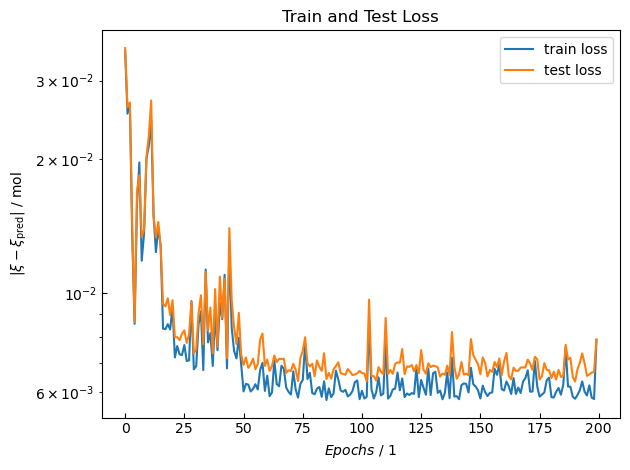

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9503951451346901
Test Dataset: R^2 = 0.9657792997142678


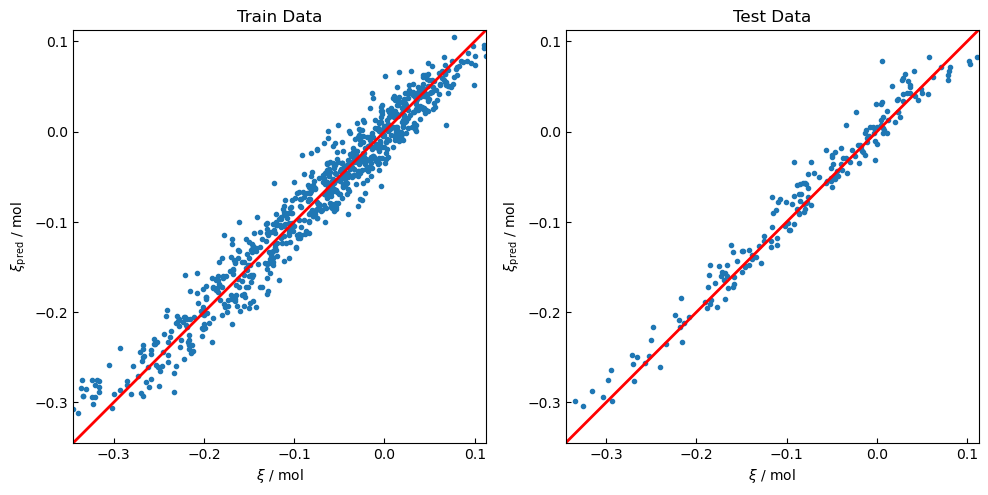

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())


print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))    

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

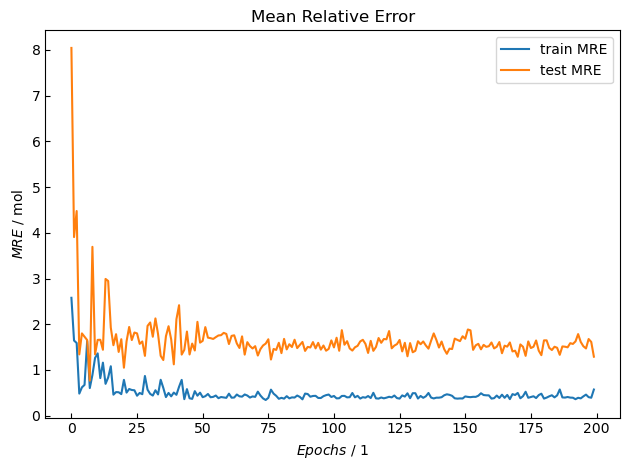

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

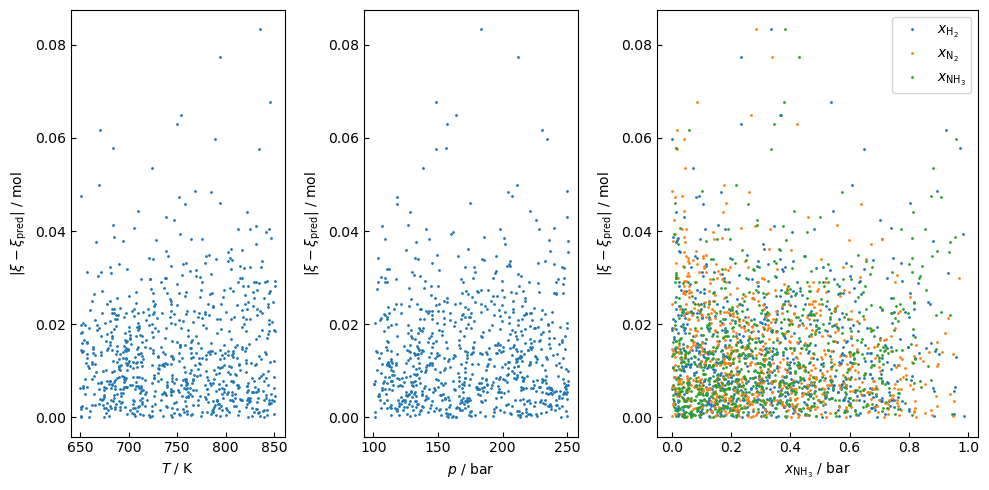

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

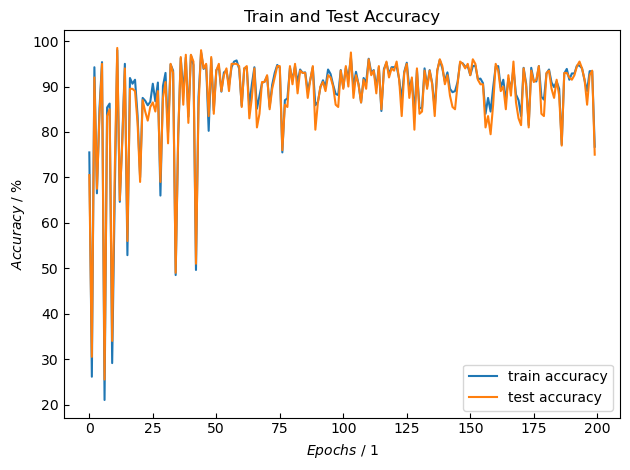

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[8.1185e+02, 1.1529e+02, 4.6300e-01, 1.4389e-01, 3.9311e-01],
        [8.4285e+02, 1.9964e+02, 6.3369e-01, 4.1642e-02, 3.2467e-01],
        [7.2624e+02, 2.0181e+02, 6.3072e-01, 4.9557e-02, 3.1972e-01],
        [7.5320e+02, 1.9549e+02, 4.8346e-01, 6.9911e-02, 4.4662e-01],
        [6.7423e+02, 2.2767e+02, 5.7088e-01, 2.4901e-04, 4.2887e-01],
        [8.0518e+02, 1.6637e+02, 1.9071e-01, 6.8293e-01, 1.2636e-01],
        [6.8824e+02, 1.3350e+02, 2.3740e-01, 3.0713e-01, 4.5547e-01],
        [6.8448e+02, 1.7290e+02, 1.5087e-02, 2.0371e-01, 7.8120e-01],
        [8.3936e+02, 2.2321e+02, 5.7842e-01, 3.3966e-01, 8.1922e-02],
        [7.0393e+02, 1.4382e+02, 6.7222e-01, 8.9779e-02, 2.3800e-01],
        [7.9147e+02, 1.5274e+02, 7.5006e-01, 4.5556e-02, 2.0438e-01],
        [7.7550e+02, 1.6932e+02, 1.9191e-01, 7.5363e-01, 5.4461e-02],
        [7.7178e+02, 1.3325e+02, 7.4117e-01, 2.6780e-02, 2.3205e-01],
        [8.4941e+02, 1.5903e+02, 9.5226e-01, 1.0870e-02, 3.6873e-02],
        [8.2123e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.9171, 0.6841, 0.9475, 0.9626, 1.0391], requires_grad=True),
 Parameter containing:
 tensor([-0.0922,  0.0623,  0.0061,  0.1972, -0.0547], requires_grad=True),
 Parameter containing:
 tensor([[-0.1432, -0.3980,  0.0090, -0.1010,  0.0438],
         [-0.0753, -0.1828,  0.0901,  0.0240, -0.2135],
         [ 0.1125, -0.2319,  0.0968,  0.1334,  0.2747],
         [ 0.0073, -0.1170,  0.3764,  0.3620,  0.2785],
         [ 0.3130,  0.1481, -0.0458, -0.2255,  0.1422],
         [-0.3421,  0.1220,  0.1197,  0.2045, -0.0574],
         [ 0.1195, -0.2287,  0.2580,  0.1993, -0.1576],
         [ 0.1729,  0.1206,  0.0824, -0.3050, -0.4505],
         [ 0.6319, -0.0839, -0.1653,  0.1987, -0.1620],
         [-0.2095,  0.1855, -0.0219,  0.5528, -0.2808],
         [ 0.3647,  0.0818, -0.2102, -0.1368, -0.5742],
         [-0.0060, -0.0938, -0.1193,  0.0119, -0.4262],
         [ 0.1473,  0.3951, -0.1869, -0.0020,  0.4106],
         [ 0.2189, -0.1451, -0.2909, -0.0340,  0.0693],


In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0102, 0.7149, 0.6287, 0.5628, 0.4933],
        [0.8375, 0.8743, 0.7346, 0.5174, 0.9609]])
tensor([[-0.0160],
        [-0.1466]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[6.6301e+02, 1.7672e+02, 7.9700e-01, 6.3701e-02, 1.3930e-01],
        [6.8435e+02, 1.8569e+02, 2.9204e-03, 4.0842e-02, 9.5624e-01],
        [8.3647e+02, 2.4242e+02, 8.1062e-01, 4.9351e-02, 1.4003e-01],
        [6.9609e+02, 1.6460e+02, 3.8021e-01, 5.6382e-01, 5.5977e-02],
        [8.3936e+02, 2.2321e+02, 5.7842e-01, 3.3966e-01, 8.1922e-02],
        [7.3278e+02, 2.2101e+02, 5.7912e-01, 1.8778e-01, 2.3310e-01],
        [6.6215e+02, 2.4207e+02, 6.8958e-01, 5.3513e-03, 3.0507e-01],
        [7.3221e+02, 1.6659e+02, 4.1205e-01, 3.9253e-01, 1.9542e-01],
        [7.4887e+02, 2.2523e+02, 1.2329e-01, 3.7165e-01, 5.0506e-01],
        [7.6903e+02, 2.4830e+02, 3.7813e-01, 4.7029e-01, 1.5158e-01],
        [7.3619e+02, 1.2785e+02, 4.3246e-01, 3.8704e-01, 1.8050e-01],
        [6.9826e+02, 2.2055e+02, 7.6220e-01, 1.1302e-01, 1.2478e-01],
        [8.4020e+02, 2.2031e+02, 6.3112e-01, 2.8921e-01, 7.9672e-02],
        [8.4425e+02, 2.1180e+02, 4.3155e-01, 8.8767e-02, 4.7968e-01],
        [6.5689e+02,